# Whole script
* Tiling of tiffs by converting to png first then tiling the png up...
* Then saving all these tiles in a folder
* Then making predictions on all of these tiles individually and saving these to a folder

### Mount drive, install packages, import packages

In [ ]:
# mount google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# install necessary geospatial packages

!pip -q install rasterio
!pip -q install fiona
!pip -q install geopandas
!pip -q install pycrs
!pip -q install descartes 
!pip -q install pypng

     |████████████████████████████████| 19.3 MB 5.3 MB/s 
     |████████████████████████████████| 15.4 MB 4.8 MB/s 
     |████████████████████████████████| 1.0 MB 5.2 MB/s 
     |████████████████████████████████| 6.3 MB 37.6 MB/s 
     |████████████████████████████████| 48 kB 2.3 MB/s 


In [ ]:
# necessary basic libraries
import pandas as pd
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
from PIL import Image
import os
import json
import png
import math
import glob

# geospatial libraries
import rasterio
import geopandas
from geopandas.tools import sjoin
import fiona
from rasterio.plot import show
from rasterio.mask import mask
from shapely.geometry import box
import geopandas as gpd
from fiona.crs import from_epsg
import pycrs
import descartes

# Initial inspection of our tiffs, including bounds and CRS and so on

In [ ]:
### Right let's test this first with Sepilok 10cm resolution, then I need to try it with 50cm resolution.

# Read in the tiff file
data = rasterio.open('/content/drive/Shareddrives/detectreeRGB/benchmark/Ortho2015_benchmark/P4_Ortho_2015.tif')

# Gonna need to do this!
# Read in shapefile of crowns, if training on your own data!
#crowns = geopandas.read_file('/home/jovyan/lustre_scratch/sepilok_data/sep_danum_crowns_no_overlap/all_manual_crowns_no_overlap.shp')


In [ ]:
data

<open DatasetReader name='/content/drive/Shareddrives/detectreeRGB/benchmark/Ortho2015_benchmark/P4_Ortho_2015.tif' mode='r'>

In [ ]:
# let's investigate the tiff, what is the shape? Bounds? Bands? CRS?
# show a plot of it too

print('shape =', data.shape,',', data.bounds, 'and number of bands =', data.count, ', crs =', data.crs)

# have a look if you want (usually slow)
# show(data)

shape = (3470, 3440) , BoundingBox(left=285791.82599999994, bottom=582793.138, right=286135.82599999994, top=583140.1379999999) and number of bands = 3 , crs = EPSG:3182


In [ ]:
## find x and y origin of the tiff, need to set the north western corner as the origin 

print(data.bounds)
tiff_x_origin = data.bounds[0]
tiff_y_origin = data.bounds[3]
print('Tiff x origin:', tiff_x_origin)
print('Tiff y origin:', tiff_y_origin)

BoundingBox(left=285791.82599999994, bottom=582793.138, right=286135.82599999994, top=583140.1379999999)
Tiff x origin: 285791.82599999994
Tiff y origin: 583140.1379999999


# Doing tiling of a tiff here by first converting it to png and then doing tiling!

In [ ]:
### First let's read in all the bands of this tiff
### this is naturally slow...
### and we run out of memory...so maybe we should lazily load with a new approach...rioxarray

### SO I NEED TO THINK ABOUT DIAGONALS HERE
### HOW DO ORIGINS WORK FOR DIAGONALS
### IS THE PNG JUST THE CUT OUT OF THE TILE
### OR DOES IT INCLUDE THE WHITE SPACE AROUND THE TILE

### It seems like it is just saving them all as squares...which would be great...not sure how to corroborate this other than inspection by eye...bounding box perhaps?

arr = data.read()

In [ ]:
# just checking how many values we see for the different colours

np.unique(arr)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [ ]:
R = arr[0]
G = arr[1]
B = arr[2]


# stack up the bands in an order appropriate for saving with cv2, then rescale to the correct 0-255 range for cv2

rgb = np.dstack((B,G,R)) # BGR for cv2

rgb_rescaled = 255*(rgb/np.amax(rgb)) # scale the values of the bands if they are non-standard to range 0-255

#rgb_rescaled = rgb # usually rescaling is not required, but it depends on your tiff

# save this as jpg or png...we are going for png...again, named with the origin of the specific tile
cv2.imwrite('/content/drive/Shareddrives/detectreeRGB/paracou/full_png/Paracou_full_site.png', rgb_rescaled)

True

In [ ]:
### Ok, let's read in this png...this filename has changed

im = cv2.imread('/content/drive/Shareddrives/detectreeRGB/benchmark/Ortho2015_pngs/P4.png')


In [ ]:
### let's have a look at the image shape in number of pixels...

im.shape

(3470, 3440, 3)

In [ ]:
### too big to display - no problem - can check it is legit in drive

display(Image.fromarray(im))

In [ ]:
### Ok, so now I want to tile up this massive png.

import cv2
import math

img = cv2.imread("/content/drive/Shareddrives/detectreeRGB/benchmark/Ortho2015_pngs/P4.png") # 512x512

img_shape = img.shape
tile_size = (1400, 1400)
offset = (1000, 1000)

for i in np.arange(int(math.ceil(img_shape[0]/(offset[1] * 1.0)))):
    for j in np.arange(int(math.ceil(img_shape[1]/(offset[0] * 1.0)))):
        cropped_img = img[offset[1]*i:min(offset[1]*i+tile_size[1], img_shape[0]), offset[0]*j:min(offset[0]*j+tile_size[0], img_shape[1])]
        # Debugging the tiles
        cv2.imwrite("/content/drive/Shareddrives/detectreeRGB/benchmark/tiled_pngs3/" + str(i) + "_" + str(j) + ".png", cropped_img)

In [ ]:
img = cv2.imread("/content/drive/Shareddrives/detectreeRGB/benchmark/tiled_pngs3/3_0.png") # 512x512


In [ ]:
img.shape

(470, 1400, 3)

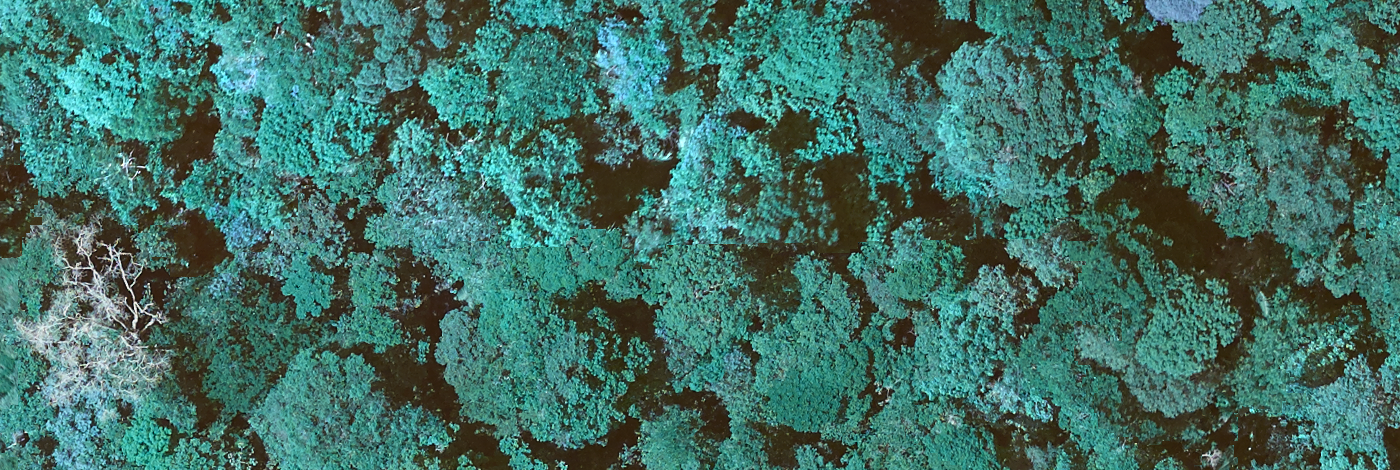

In [ ]:
display(Image.fromarray(img))

# Loop to make png tiles from all of our tiffs in a certain folder

In [ ]:
for filepath in glob.iglob('/content/drive/Shareddrives/detectreeRGB/benchmark/Ortho2015_benchmark/*.tif'):
  print('*********')
  print(filepath)
  split_folders = filepath.split('/')
  tif_filename = split_folders[-1].split('.')
  print(tif_filename)
  

*********
/content/drive/Shareddrives/detectreeRGB/benchmark/Ortho2015_benchmark/P11_Ortho_2015.tif
['P11_Ortho_2015', 'tif']
*********
/content/drive/Shareddrives/detectreeRGB/benchmark/Ortho2015_benchmark/P15_Ortho_2015.tif
['P15_Ortho_2015', 'tif']
*********
/content/drive/Shareddrives/detectreeRGB/benchmark/Ortho2015_benchmark/P4_Ortho_2015.tif
['P4_Ortho_2015', 'tif']
*********
/content/drive/Shareddrives/detectreeRGB/benchmark/Ortho2015_benchmark/P7_Ortho_2015.tif
['P7_Ortho_2015', 'tif']
*********
/content/drive/Shareddrives/detectreeRGB/benchmark/Ortho2015_benchmark/P8_Ortho_2015.tif
['P8_Ortho_2015', 'tif']
*********
/content/drive/Shareddrives/detectreeRGB/benchmark/Ortho2015_benchmark/P9_Ortho_2015.tif
['P9_Ortho_2015', 'tif']


In [ ]:
for filepath in glob.iglob('/content/drive/Shareddrives/detectreeRGB/benchmark/Ortho2015_benchmark/*.tif'):
  print('*********')
  #print(filepath)
  split_folders = filepath.split('/')
  tif_filename = split_folders[-1].split('.')
  print(tif_filename)

  # read in the tiff
  data = rasterio.open(filepath)
  print('shape =', data.shape,',', data.bounds, 'and number of bands =', data.count, ', crs =', data.crs)
  
  # determine the origin of the image (north western corner of the tiff)
  tiff_x_origin = data.bounds[0]
  tiff_y_origin = data.bounds[3]
  print('Tiff x origin:', tiff_x_origin)
  print('Tiff y origin:', tiff_y_origin)

  # read in the tiff as an array
  arr = data.read()
  
  # read in red, green and blue bands
  R = arr[0]
  G = arr[1]
  B = arr[2]

  # stack into a large numpy array
  rgb = np.dstack((B,G,R)) # BGR for cv2

  # rescale the data using 0-255 scale needed for cv2. We use np.amax to maximum value in the tiff as some tiffs use non-standard values for RGB

  rgb_rescaled = 255*(rgb/np.amax(rgb)) # scale the values of the bands if they are non-standard to range 0-255

  # save this as jpg or png...we are going for png...again, named with the origin of the specific tile
  cv2.imwrite('/content/drive/Shareddrives/detectreeRGB/benchmark/full_pngs_of_benchmark_plots/' + tif_filename[0] + '.png', rgb_rescaled)

  ### Ok, let's read in this png

  img = cv2.imread('/content/drive/Shareddrives/detectreeRGB/benchmark/full_pngs_of_benchmark_plots/' + tif_filename[0] + '.png') # 512x512

  img_shape = img.shape
  print(img_shape)

  ### define the size of tile in pixels and the required offset
  tile_size = (1400, 1400)
  offset = (1000, 1000)

  for i in np.arange(int(math.ceil(img_shape[0]/(offset[1] * 1.0)))):
      for j in np.arange(int(math.ceil(img_shape[1]/(offset[0] * 1.0)))):
          cropped_img = img[offset[1]*i:min(offset[1]*i+tile_size[1], img_shape[0]), offset[0]*j:min(offset[0]*j+tile_size[0], img_shape[1])]
          # Debugging the tiles
          ### save the tiled pngs with the original tiff name and with the position of the tile
          cv2.imwrite("/content/drive/Shareddrives/detectreeRGB/benchmark/all_tiled_pngs_direct_from_png/" + tif_filename[0] + '_' + str(i) + "_" + str(j) + ".png", cropped_img)



*********
['P11_Ortho_2015', 'tif']
shape = (3450, 3450) , BoundingBox(left=286069.326, bottom=581153.938, right=286414.32600000006, top=581498.938) and number of bands = 3 , crs = EPSG:3182
Tiff x origin: 286069.326
Tiff y origin: 581498.938
(3450, 3450, 3)
*********
['P15_Ortho_2015', 'tif']
shape = (3470, 3530) , BoundingBox(left=286241.82599999994, bottom=583486.1379999999, right=286594.82599999994, top=583833.138) and number of bands = 3 , crs = EPSG:3182
Tiff x origin: 286241.82599999994
Tiff y origin: 583833.138
(3470, 3530, 3)
*********
['P4_Ortho_2015', 'tif']
shape = (3470, 3440) , BoundingBox(left=285791.82599999994, bottom=582793.138, right=286135.82599999994, top=583140.1379999999) and number of bands = 3 , crs = EPSG:3182
Tiff x origin: 285791.82599999994
Tiff y origin: 583140.1379999999
(3470, 3440, 3)
*********
['P7_Ortho_2015', 'tif']
shape = (3450, 3470) , BoundingBox(left=285942.82599999994, bottom=582455.6379999999, right=286289.82599999994, top=582800.6379999999) a

# Now doing prediction on the tiles that we have just made using detectreeRGB.

### Package installation and import.

In [ ]:
### install detectron2 and dependency 

!pip -q install pyyaml==5.1

# This is the current pytorch version on Colab. Uncomment this if Colab changes its pytorch version
# !pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html

# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
#!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.9/index.html

### colab has updated it's pytorch version...need new Detectron2 version
!pip -q install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.10/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

     |████████████████████████████████| 274 kB 5.3 MB/s 
     |████████████████████████████████| 7.0 MB 483 kB/s 
     |████████████████████████████████| 49 kB 2.8 MB/s 
     |████████████████████████████████| 130 kB 8.3 MB/s 
     |████████████████████████████████| 145 kB 32.1 MB/s 
     |████████████████████████████████| 74 kB 3.3 MB/s 
     |████████████████████████████████| 749 kB 46.9 MB/s 
     |████████████████████████████████| 843 kB 46.7 MB/s 
     |████████████████████████████████| 112 kB 44.1 MB/s 


In [ ]:
# check pytorch installation: 
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
#assert torch.__version__.startswith("1.9")   # please manually install torch 1.9 if Colab changes its default version

from IPython.display import display, clear_output

1.10.0+cu111 True


In [ ]:
# Import necessary parts of detectron2
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode
from detectron2.utils.visualizer import ColorMode
from detectron2.engine import DefaultTrainer

# tensorboard?
#%load_ext tensorboard
#%tensorboard --logdir output

# necessary libraries
import pandas as pd
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
from PIL import Image
import os
import numpy as np
import json
import glob
import urllib

# import geospatial libraries
import rasterio
from rasterio.transform import from_origin
import rasterio.features

import fiona

from shapely.geometry import shape, mapping, box
from shapely.geometry.multipolygon import MultiPolygon

#from google.colab.patches import cv2_imshow

# import visualisation libraries

#import holoviews as hv
#from IPython.display import display
#import geoviews.tile_sources as gts

#import hvplot.pandas
#import hvplot.xarray

#hv.extension('bokeh', width=100)

In [ ]:
# Make sure the inevitable error messages are useful.
CUDA_LAUNCH_BLOCKING="1"

In [ ]:
# define the URL to retrieve the model from Zenodo
fn = 'model_final.pth'
url = f'https://zenodo.org/record/5515408/files/{fn}?download=1'

urllib.request.urlretrieve(url, '/content/drive/Shareddrives/detectreeRGB/weights' + '/' + fn)

('/content/drive/Shareddrives/detectreeRGB/weights/model_final.pth',
 <http.client.HTTPMessage at 0x7fa270c4a5d0>)

In [ ]:
# Setup to predict on new images, here setting up for the trees_test dataset, but can also use this setup
# for predicting on individual images as seen 2 cells down

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

# if we want to make predictions using a CPU
cfg.MODEL.DEVICE='cuda'  # 'cpu' or 'cuda'

### path to the saved pre-trained model weights
cfg.MODEL.WEIGHTS = '/content/drive/Shareddrives/detectreeRGB/weights/model_final.pth'

# set confidence threshold at which we predict
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.15

predictor = DefaultPredictor(cfg)

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


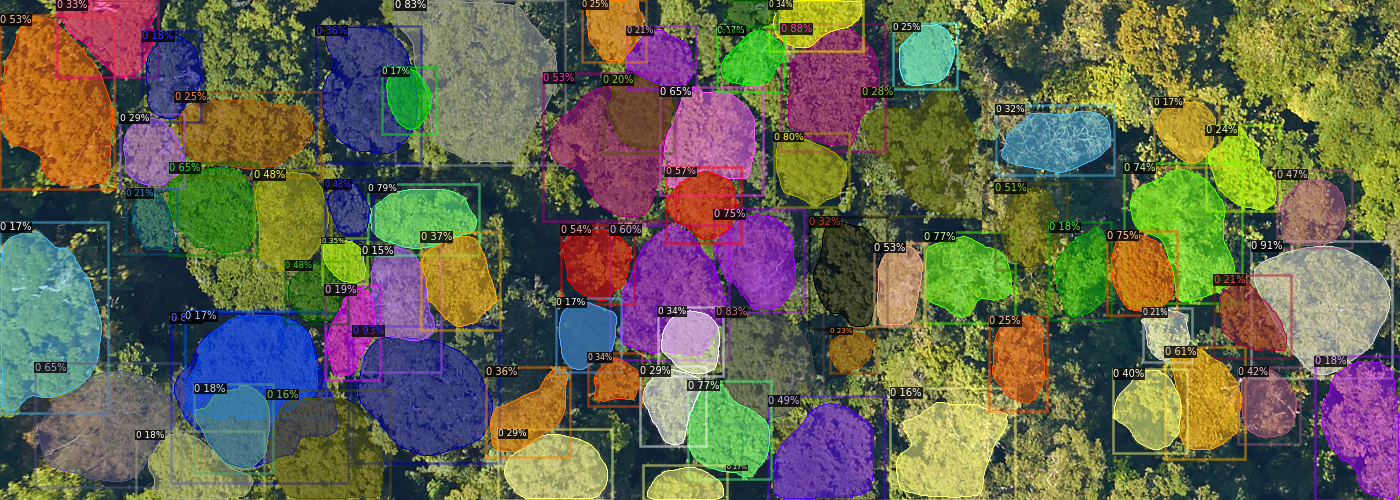

In [ ]:
# make and visualise predictions, on a particular file, just to check these weights are working ok 

# give the image that we are trying to predict on


im = cv2.imread("/content/drive/Shareddrives/detectreeRGB/benchmark/all_tiled_pngs_direct_from_png/P8_Ortho_2015_3_0.png")   #tile_286550_583800 #tile_286250_583700
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1], scale=1)   
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
image = cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB)
display(Image.fromarray(image))

In [ ]:
### Just doing some pre-work here to split up strings and so on...IGNORE

import glob

for filepath in glob.iglob('/content/drive/Shareddrives/detectreeRGB/benchmark/all_tiled_pngs_direct_from_png/*.png'):
    colors = filepath.split('/')
    #print(colors[-1])
    smthg = colors[-1].split('.')
    #print(wanker[0])
    nextthing = smthg[0].split('_')
    print(nextthing)
    print(nextthing[3])

['P11', 'Ortho', '2015', '0', '0']
0
['P11', 'Ortho', '2015', '0', '1']
0
['P11', 'Ortho', '2015', '0', '2']
0
['P11', 'Ortho', '2015', '0', '3']
0
['P11', 'Ortho', '2015', '1', '0']
1
['P11', 'Ortho', '2015', '1', '1']
1
['P11', 'Ortho', '2015', '1', '2']
1
['P11', 'Ortho', '2015', '1', '3']
1
['P11', 'Ortho', '2015', '2', '0']
2
['P11', 'Ortho', '2015', '2', '1']
2
['P11', 'Ortho', '2015', '2', '2']
2
['P11', 'Ortho', '2015', '2', '3']
2
['P11', 'Ortho', '2015', '3', '0']
3
['P11', 'Ortho', '2015', '3', '1']
3
['P11', 'Ortho', '2015', '3', '2']
3
['P11', 'Ortho', '2015', '3', '3']
3
['P15', 'Ortho', '2015', '0', '0']
0
['P15', 'Ortho', '2015', '0', '1']
0
['P15', 'Ortho', '2015', '0', '2']
0
['P15', 'Ortho', '2015', '0', '3']
0
['P15', 'Ortho', '2015', '1', '0']
1
['P15', 'Ortho', '2015', '1', '1']
1
['P15', 'Ortho', '2015', '1', '2']
1
['P15', 'Ortho', '2015', '1', '3']
1
['P15', 'Ortho', '2015', '2', '0']
2
['P15', 'Ortho', '2015', '2', '1']
2
['P15', 'Ortho', '2015', '2', '2']
2
[

In [ ]:
# checking scaling - ignore!

tiff_y_origin+(png_y_index*100)

582893.138

In [ ]:
print('Tiff y origin:', tiff_y_origin)

Tiff y origin: 582793.138


In [ ]:
### this is working out - IGNORE

for filepath in glob.iglob('/content/drive/Shareddrives/detectreeRGB/benchmark/tiled_pngs3/*.png'):
    print(filepath)    
    split_folders = filepath.split('/')
    png_filename = split_folders[-1].split('.')
    print(png_filename)
    png_index = png_filename[0].split('_')
    print(png_index)
    png_x_index = int(png_index[0])
    png_y_index = int(png_index[1])
    #print(png_x_index)
    #print(png_y_index)

/content/drive/Shareddrives/detectreeRGB/benchmark/tiled_pngs3/0_3.png
['0_3', 'png']
['0', '3']
/content/drive/Shareddrives/detectreeRGB/benchmark/tiled_pngs3/1_1.png
['1_1', 'png']
['1', '1']
/content/drive/Shareddrives/detectreeRGB/benchmark/tiled_pngs3/0_0.png
['0_0', 'png']
['0', '0']
/content/drive/Shareddrives/detectreeRGB/benchmark/tiled_pngs3/1_3.png
['1_3', 'png']
['1', '3']
/content/drive/Shareddrives/detectreeRGB/benchmark/tiled_pngs3/0_1.png
['0_1', 'png']
['0', '1']
/content/drive/Shareddrives/detectreeRGB/benchmark/tiled_pngs3/2_1.png
['2_1', 'png']
['2', '1']
/content/drive/Shareddrives/detectreeRGB/benchmark/tiled_pngs3/1_0.png
['1_0', 'png']
['1', '0']
/content/drive/Shareddrives/detectreeRGB/benchmark/tiled_pngs3/2_0.png
['2_0', 'png']
['2', '0']
/content/drive/Shareddrives/detectreeRGB/benchmark/tiled_pngs3/0_2.png
['0_2', 'png']
['0', '2']
/content/drive/Shareddrives/detectreeRGB/benchmark/tiled_pngs3/1_2.png
['1_2', 'png']
['1', '2']
/content/drive/Shareddrives/de

In [ ]:
resolution = 0.1

In [ ]:
### Ok this now works...

# loop through all pngs, once they have been tiled with tiling script


import glob

for filepath in glob.iglob('/content/drive/Shareddrives/detectreeRGB/benchmark/all_tiled_pngs_direct_from_png/*.png'):
    print(filepath)
    img = cv2.imread(filepath)
    outputs = predictor(img)
    mask_array = outputs['instances'].pred_masks.cpu().numpy()

    # get confidence scores too 
    mask_array_scores = outputs['instances'].scores.cpu().numpy()

    num_instances = mask_array.shape[0]
    mask_array_instance = []
    output = np.zeros_like(mask_array) 

    mask_array_instance.append(mask_array)
    output = np.where(mask_array_instance[0] == True, 255, output)
    fresh_output = output.astype(np.float)
    print(fresh_output.shape)
    #x_scaling = img.shape[1]/fresh_output.shape[2]
    #y_scaling = img.shape[0]/fresh_output.shape[1]
    x_scaling = (img.shape[1] * resolution)/fresh_output.shape[2]
    y_scaling = (img.shape[0] * resolution)/fresh_output.shape[1]

    print('image shape:', img.shape)
    print('fresh_output shape:', fresh_output.shape)
    print('x scaling:', x_scaling)
    print('y scaling:', y_scaling)
    # this is an affine transform. This needs to be altered significantly.
    #transform = from_origin(int(filepath[-17:-11])-20, int(filepath[-10:-4])+120, y_scaling, x_scaling)
    
    # here splitting filenames to get the indexes that we want
    split_folders = filepath.split('/')
    png_filename = split_folders[-1].split('.')
    png_index = png_filename[0].split('_')
    png_x_index = int(png_index[4])  ### It is possible that this should be written so that the indicies are the other way around...
    png_y_index = int(png_index[3])
    
    ### from_origin takes (west, north, xsize, ysize)
    transform = from_origin(tiff_x_origin+(png_x_index*100), tiff_y_origin - (png_y_index*100), x_scaling, y_scaling)  ## I removed the buffering here...and swapped x and y scaling
    #print(transform)


    output_raster =  '/content/drive/Shareddrives/detectreeRGB/benchmark/all_plots_tiled_100m_from_png/rasters/' + 'predicted_raster_' + str(tiff_x_origin+(png_x_index*100)) + '_' + str(tiff_y_origin+(png_y_index*100)) + '.tif'

    ### perhaps here try to remove the new_dataset.write() function...can we do it without having to save this raster?
    new_dataset = rasterio.open(output_raster, 'w', driver='GTiff',
                                    height = fresh_output.shape[1], width = fresh_output.shape[2], count = fresh_output.shape[0],
                                    dtype=str(fresh_output.dtype),
                                    crs='EPSG:32622',  
                                    transform=transform)

    new_dataset.write(fresh_output)
    new_dataset.close()

    with rasterio.open(output_raster) as src:
        shp_schema = {'geometry': 'MultiPolygon','properties': {'pixelvalue': 'int', 'score': 'float'}}    

        crs = src.crs
        for i in range(src.count):
            src_band = src.read(i+1)
            src_band = np.float32(src_band)
            
            # this is odd, perhaps should be i - 1
            conf = mask_array_scores[i-2]
            # Keep track of unique pixel values in the input band...I should probably hash this out
            unique_values = np.unique(src_band)
            # Polygonize with Rasterio. `shapes()` returns an iterable
            # of (geom, value) as tuples
            shapes = list(rasterio.features.shapes(src_band, transform=src.transform))

          
            if i == 0:
                with fiona.open('/content/drive/Shareddrives/detectreeRGB/benchmark/all_plots_tiled_100m_from_png/shapes/' + 'predicted_polygons_' + str(tiff_x_origin+(png_x_index*100)) + '_' + str(tiff_y_origin+(png_y_index*100)) + '.shp', 'w', 'ESRI Shapefile',
                                shp_schema, crs) as shp:
                    polygons = [shape(geom) for geom, value in shapes if value == 255.0]                                        
                    multipolygon = MultiPolygon(polygons)
                            # simplify not needed here
                            #multipolygon = multipolygon_a.simplify(0.1, preserve_topology=False)                    
                    shp.write({
                              'geometry': mapping(multipolygon),
                              'properties': {'pixelvalue': int(unique_values[1]), 'score': float(conf)} 
                              })
            else:
                with fiona.open('/content/drive/Shareddrives/detectreeRGB/benchmark/all_plots_tiled_100m_from_png/shapes/' + 'predicted_polygons_' + str(tiff_x_origin+(png_x_index*100)) + '_' + str(tiff_y_origin+(png_y_index*100))+'.shp', 'a', 'ESRI Shapefile',
                                shp_schema, crs) as shp:
                    polygons = [shape(geom) for geom, value in shapes if value == 255.0]                                        
                    multipolygon = MultiPolygon(polygons)
                            # simplify not needed here
                            #multipolygon = multipolygon_a.simplify(0.1, preserve_topology=False)                    
                    shp.write({
                              'geometry': mapping(multipolygon),
                              'properties': {'pixelvalue': int(unique_values[1]), 'score': float(conf)} 
                              })
        


/content/drive/Shareddrives/detectreeRGB/benchmark/all_tiled_pngs_direct_from_png/P11_Ortho_2015_0_0.png


/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


(79, 1400, 1400)
image shape: (1400, 1400, 3)
fresh_output shape: (79, 1400, 1400)
x scaling: 0.1
y scaling: 0.1
/content/drive/Shareddrives/detectreeRGB/benchmark/all_tiled_pngs_direct_from_png/P11_Ortho_2015_0_1.png
(86, 1400, 1400)
image shape: (1400, 1400, 3)
fresh_output shape: (86, 1400, 1400)
x scaling: 0.1
y scaling: 0.1
/content/drive/Shareddrives/detectreeRGB/benchmark/all_tiled_pngs_direct_from_png/P11_Ortho_2015_0_2.png
(81, 1400, 1400)
image shape: (1400, 1400, 3)
fresh_output shape: (81, 1400, 1400)
x scaling: 0.1
y scaling: 0.1
/content/drive/Shareddrives/detectreeRGB/benchmark/all_tiled_pngs_direct_from_png/P11_Ortho_2015_0_3.png
(45, 1400, 450)
image shape: (1400, 450, 3)
fresh_output shape: (45, 1400, 450)
x scaling: 0.1
y scaling: 0.1
/content/drive/Shareddrives/detectreeRGB/benchmark/all_tiled_pngs_direct_from_png/P11_Ortho_2015_1_0.png
(86, 1400, 1400)
image shape: (1400, 1400, 3)
fresh_output shape: (86, 1400, 1400)
x scaling: 0.1
y scaling: 0.1
/content/drive/Sha

In [ ]:
### let's first read in the data.
### Firstly the tiff file of our area of interest, secondly our shapefile of manually delineated crowns, 
### if we are training the model rather than simply using a pre-trained model.

# Read in a tiff file
data = rasterio.open('/content/drive/Shareddrives/detectreeRGB/benchmark/Ortho2015_benchmark/P4_Ortho_2015.tif')

# Read in shapefile of crowns, if training on your own data!
#crowns = geopandas.read_file('/home/jovyan/lustre_scratch/sepilok_data/sep_danum_crowns_no_overlap/all_manual_crowns_no_overlap.shp')

# have a look at the crowns if we like
#crowns

In [ ]:
import numpy as np
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling

dst_crs = 'EPSG:32622'

with rasterio.open('/content/drive/Shareddrives/detectreeRGB/benchmark/Ortho2015_benchmark/P15_Ortho_2015.tif') as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rasterio.open('/tmp/RGB_byte_wgs84.tif', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)

In [ ]:
data = rasterio.open('/tmp/RGB_byte_wgs84.tif')

In [ ]:
# let's investigate the tiff, what is the shape? Bounds? Bands? CRS?
# show a plot of it too

print('shape =', data.shape,',', data.bounds, 'and number of bands =', data.count, ',crs =', data.crs)

# have a look if you want (usually slow)
#show(data)

shape = (3470, 3530) , BoundingBox(left=286241.8260000305, bottom=583486.1380191577, right=286594.8260000361, top=583833.1380191632) and number of bands = 3 ,crs = EPSG:32622


#### Looping through a set of tiles, to chop up the tiffs and crowns, and save as PNGs and GeoJSONs 

In [ ]:
# just defining a function we are going to use shortly.

def getFeatures(gdf):
        """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
        return [json.loads(gdf.to_json())['features'][0]['geometry']]

In [ ]:
### Code just to make a PNG from a whole tile

#data = rasterio.open('/content/drive/Shareddrives/detectreeRGB/benchmark/Ortho2015_benchmark/P4_Ortho_2015.tif')

# read it as an array
arr = data.read()
    
# check the shape of the tile if you wish
print(arr.shape)
    
# each band of the tiled tiff is a colour!
R = arr[0]
G = arr[1]
B = arr[2]
    
# stack up the bands in an order appropriate for saving with cv2, then rescale to the correct 0-255 range for cv2
    
rgb = np.dstack((B,G,R)) # BGR for cv2
rgb_rescaled = rgb # scale to image
    
# save this as jpg or png...we are going for png...again, named with the origin of the specific tile
cv2.imwrite('/content/drive/Shareddrives/detectreeRGB/benchmark/Ortho2015_pngs/P9.png', rgb_rescaled)
    

(3, 3490, 3450)


True

In [ ]:
data = rasterio.open('/content/drive/Shareddrives/detectreeRGB/benchmark/Ortho2015_benchmark/P15_Ortho_2015.tif')
data.bounds

BoundingBox(left=286241.82599999994, bottom=583486.1379999999, right=286594.82599999994, top=583833.138)

In [ ]:
### version working as of 13/8/21

# Read in a tiff file, and the csv of the tiles we expect
#data = rasterio.open('/content/drive/Shareddrives/detectreeRGB/benchmark/Ortho2015_benchmark/P15_Ortho_2015.tif')

# Read in the shapefile of manual crowns - again, this is only if you are wanting to train with your own crowns
#crowns = geopandas.read_file('/home/jovyan/lustre_scratch/sepilok_data/sep_danum_crowns_no_overlap/all_manual_crowns_no_overlap.shp')

# read in a csv containing the origin x and y coordinates of the tiles you wish to slice up...
# this needs to be updated to just be Sepilok tiles before release
# James - this is on the drive (where the code points to!)
# tiles = pd.read_csv('/content/drive/Shareddrives/detectreegb/benchmark/benchmark_tiles_P11.csv')

#######################################
#### PROBLEM OF STUFF BEING STRETCHED ON THE SIDES
#### OF THE PREDICTIONS 
#### NEED TO THINK ABOUT THIS AND HOW TO DEAL WITH IT
#######################################

# set the desired buffer, tile width, heght and resolution of the tiff tiles. Suggested values are given below. The buffer will be affected by the area of tree crowns in your region of forest.
buffer = 20
tile_width = 100
tile_height = 100
resolution = 0.1 # in metres per pixel
scaling = 1/resolution  # scaling parameter to transform the shapefile coordinates so they match the png

# this for loop can be rewritten to work with out requiring a csv e.g. for minx in range(V, W, step): etc.
#for ind in tiles.index:
#    minx = tiles['Origin X coordinate'][ind] 
#    miny = tiles['Origin Y coordinate'][ind]

for minx in range(286250, 286550, 100):
    for miny in range(583500, 583800, 100):    
      # define the bounding box of the whole tile, including the buffer
      bbox = box(minx-buffer, miny-buffer, minx+tile_width+buffer, miny+tile_height+buffer)
      # define the bounding box of the tile, excluding the buffer (hence selecting just the central part of the tile)
      bbox_central = box(minx, miny, minx+tile_width, miny+tile_height)
      # turn the bounding boxes into geopandas DataFrames
      geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=from_epsg(32622))
      geo_central = gpd.GeoDataFrame({'geometry': bbox_central}, index=[0], crs=from_epsg(32622))   #3182
      
      ### here we are cropping the tiff to the bounding box of the tile we want
      coords = getFeatures(geo)
      #print(coords)
      
      # define the tile as a mask of the whole tiff with just the bounding box
      out_img, out_transform = mask(data, shapes=coords, crop=True)
      
      # copy the metadata
      out_meta = data.meta.copy()
      #print(out_meta)
      epsg_code = int(data.crs.data['init'][5:])
      #print(epsg_code)
      
      # update the metadata
      out_meta.update({"driver": "GTiff",
                      "height": out_img.shape[1],
                      "width": out_img.shape[2],
                      "transform": out_transform
                      })
      
      # here we are saving the tile as a new tiff, named by the origin of the tile
      out_tif = '/content/drive/Shareddrives/detectreeRGB/benchmark/all_tiled_100m_32622/tiffs/tile_'+str(minx)+'_'+str(miny)+'.tif'
      with rasterio.open(out_tif, "w", **out_meta) as dest:
                        dest.write(out_img)
      
      # read in the tile we have just saved
      clipped = rasterio.open('/content/drive/Shareddrives/detectreeRGB/benchmark/all_tiled_100m_32622/tiffs/tile_'+str(minx)+'_'+str(miny)+'.tif')
      # read it as an array
      arr = clipped.read()
      
      # check the shape of the tile if you wish
      #print(arr.shape)
      
      # each band of the tiled tiff is a colour!
      R = arr[0]
      G = arr[1]
      B = arr[2]
      
      # stack up the bands in an order appropriate for saving with cv2, then rescale to the correct 0-255 range for cv2
      
      rgb = np.dstack((B,G,R)) # BGR for cv2
      rgb_rescaled = rgb # scale to image
      
      # save this as jpg or png...we are going for png...again, named with the origin of the specific tile
      cv2.imwrite('/content/drive/Shareddrives/detectreeRGB/benchmark/all_tiled_100m_32622/pngs/tile_'+str(minx)+'_'+str(miny)+'.png', rgb_rescaled)
      
      ### now we have dealt with tiling the tiff, we want to deal with tiling the crowns...
      ### IF we have manual crowns we are going to use for training
      ### THEN uncomment the following 4 lines of code
      
      ### select the crowns that intersect the non-buffered central section of the tile using the inner join
      #overlapping_crowns = sjoin(crowns, geo_central, how="inner")
      
      ### translate to 0,0 to overlay on png
      #moved = overlapping_crowns.translate(-minx+buffer, -miny+buffer)  
      
      ### scale to deal with the resolution
      #moved_scaled = moved.scale(scaling, scaling, origin=(0, 0)) 
      
      ### save as a geojson, a format compatible with detectron2, again named by the origin of the tile
      #moved_scaled.to_file(driver = 'GeoJSON', 
      #                           filename= '/home/jovyan/lustre_scratch/sepilok_data/spare_crowns/tile_'+str(minx)+'_'+str(miny)+'.geojson')
          

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axi